In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [3]:
data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,ccs
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [4]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [6]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

In [15]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [7]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

## Training

In [72]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(8,)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1)
])
optimizer = tf.train.AdamOptimizer(0.005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_7 (Batch (None, 8)                 32        
_________________________________________________________________
activation_8 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 113
Trainable params: 97
Non-trainable params: 16
_________________________________________________________________


In [74]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [75]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 825 samples, validate on 102 samples
Epoch 1/1000
825/825 [==============================] - 1s 2ms/step - loss: 1556.2568 - mean_absolute_error: 35.6364 - val_loss: 1524.0264 - val_mean_absolute_error: 35.4478
Epoch 2/1000
825/825 [==============================] - 0s 394us/step - loss: 1482.1891 - mean_absolute_error: 34.7821 - val_loss: 1453.1888 - val_mean_absolute_error: 34.6330
Epoch 3/1000
825/825 [==============================] - 0s 377us/step - loss: 1398.7134 - mean_absolute_error: 33.8072 - val_loss: 1366.8498 - val_mean_absolute_error: 33.6553
Epoch 4/1000
825/825 [==============================] - 0s 352us/step - loss: 1292.3645 - mean_absolute_error: 32.5827 - val_loss: 1266.6299 - val_mean_absolute_error: 32.4897
Epoch 5/1000
825/825 [==============================] - 0s 381us/step - loss: 1169.2455 - mean_absolute_error: 31.0555 - val_loss: 1153.0261 - val_mean_absolute_error: 31.0666
Epoch 6/1000
825/825 [==============================] - 0s 425us/step - loss

Epoch 48/1000
825/825 [==============================] - 0s 385us/step - loss: 104.9704 - mean_absolute_error: 8.1622 - val_loss: 93.3052 - val_mean_absolute_error: 7.6867
Epoch 49/1000
825/825 [==============================] - 0s 400us/step - loss: 99.4499 - mean_absolute_error: 7.9609 - val_loss: 92.3915 - val_mean_absolute_error: 7.6614
Epoch 50/1000
825/825 [==============================] - 0s 369us/step - loss: 100.3074 - mean_absolute_error: 7.8904 - val_loss: 91.3765 - val_mean_absolute_error: 7.6817
Epoch 51/1000
825/825 [==============================] - 0s 270us/step - loss: 104.5646 - mean_absolute_error: 8.1146 - val_loss: 92.5584 - val_mean_absolute_error: 7.7404
Epoch 52/1000
825/825 [==============================] - 0s 292us/step - loss: 101.5846 - mean_absolute_error: 7.9051 - val_loss: 94.7268 - val_mean_absolute_error: 7.9910
Epoch 53/1000
825/825 [==============================] - 0s 255us/step - loss: 94.8064 - mean_absolute_error: 7.7256 - val_loss: 94.1176 - va

Epoch 96/1000
825/825 [==============================] - 0s 362us/step - loss: 58.3767 - mean_absolute_error: 5.7607 - val_loss: 60.9997 - val_mean_absolute_error: 6.0292
Epoch 97/1000
825/825 [==============================] - 0s 431us/step - loss: 65.1670 - mean_absolute_error: 6.2304 - val_loss: 61.5196 - val_mean_absolute_error: 6.0933
Epoch 98/1000
825/825 [==============================] - 0s 337us/step - loss: 64.1032 - mean_absolute_error: 6.2490 - val_loss: 62.2491 - val_mean_absolute_error: 6.0564
Epoch 99/1000
825/825 [==============================] - 0s 370us/step - loss: 62.4672 - mean_absolute_error: 6.1487 - val_loss: 60.6293 - val_mean_absolute_error: 5.9616
Epoch 100/1000
825/825 [==============================] - 0s 454us/step - loss: 69.6333 - mean_absolute_error: 6.5382 - val_loss: 61.3082 - val_mean_absolute_error: 5.9734
Epoch 101/1000
825/825 [==============================] - 0s 466us/step - loss: 59.9687 - mean_absolute_error: 6.0045 - val_loss: 62.4976 - val_

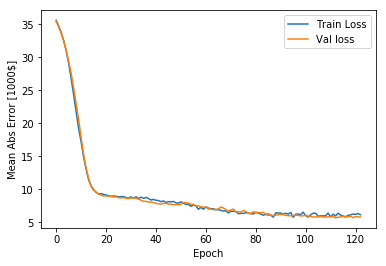

In [76]:
plot_history(history)

In [77]:
pred = model.predict(X_test)
msse(pred.flatten(), y_test)

60.91510140180172

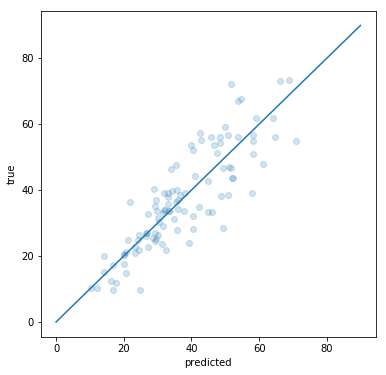

In [78]:
plot_predictions(pred, y_test)

In [38]:
weights = model.get_weights()
np.save('relu_weights', weights, allow_pickle=True)